In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/baseline_ED_feat.csv")
gen =pd.read_csv("../data/GenED_feat.csv")

paper_cols = ["log","ratio_unique_traces_per_trace", "ratio_most_common_variant", 'ratio_top_10_variants', 'epa_normalized_variant_entropy', 'epa_normalized_sequence_entropy', 'epa_normalized_sequence_entropy_linear_forgetting', 'epa_normalized_sequence_entropy_exponential_forgetting'] 
df= df[paper_cols]

print(gen.shape, df.shape)
#print(gen.columns == df.columns)

(467, 8) (26, 8)


In [3]:
df['source']='Real'
gen['source']='Generated'
both_df = pd.concat([df, gen])
print(both_df.shape)
both_df.head()

(493, 9)


,log,ratio_unique_traces_per_trace,ratio_most_common_variant,ratio_top_10_variants,epa_normalized_variant_entropy,epa_normalized_sequence_entropy,epa_normalized_sequence_entropy_linear_forgetting,epa_normalized_sequence_entropy_exponential_forgetting,source
0,BPIC16wm_p,0.002882,0.295803,0.714106,0.000000,0.000000,0.000000,0.000000,Real
1,BPIC15f5,0.997405,0.001730,0.102076,0.648702,0.603260,0.342410,0.404580,Real
2,BPIC15f1,0.975813,0.006672,0.121768,0.652855,0.610294,0.270241,0.363928,Real
3,BPIC19,0.047562,0.199758,0.946368,0.645530,0.328029,0.320185,0.320282,Real
4,BPIC14dia_p,0.496847,0.037455,0.552836,0.774743,0.608350,0.305614,0.377416,Real


In [4]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(both_df.drop(['log','source'], axis=1))
imp_df = imp_mean.transform(both_df.drop(['log','source'], axis=1))
imp_df = pd.DataFrame(imp_df, columns = both_df.columns[2:])
print("Before:", len(both_df.loc[:, both_df.isna().any()].columns), "columns in", len(both_df.loc[:, both_df.isna().any()]), 'rows')
print("After:", len(imp_df.loc[:, imp_df.isna().any()].columns))

Before: 0 columns in 493 rows
After: 0


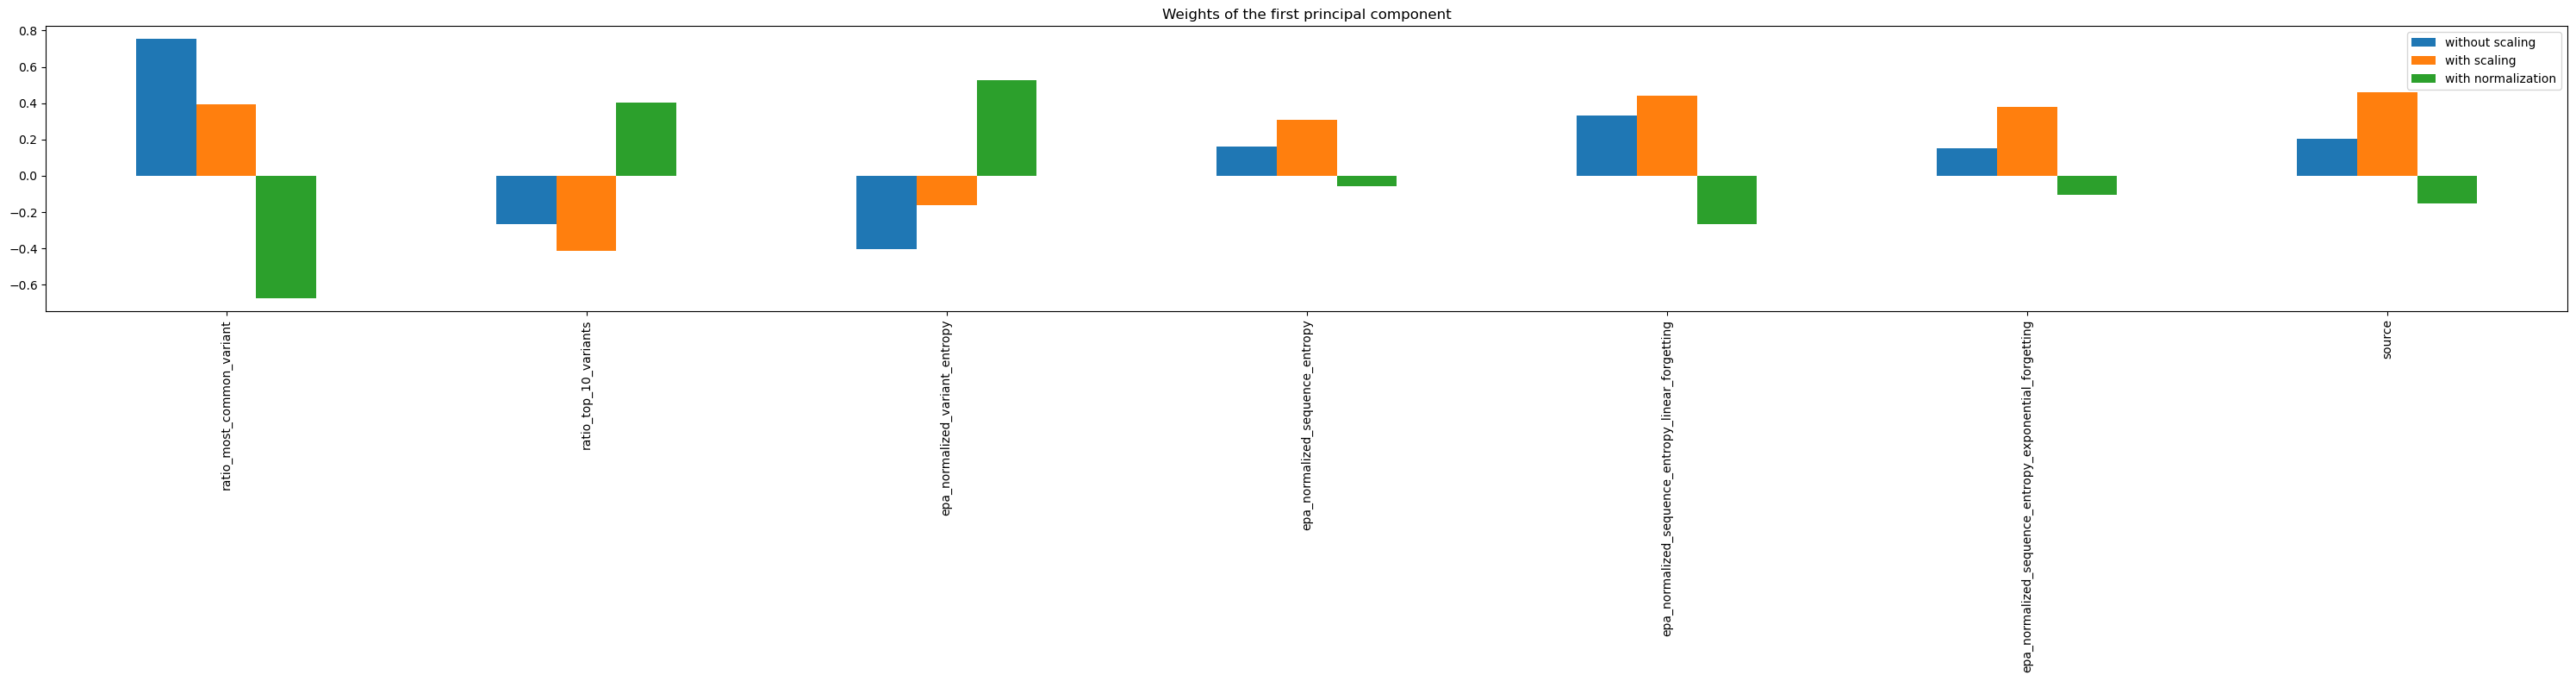

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

X = imp_df
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X)
normed_X = Normalizer(norm="l2").fit_transform(X)


import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2).fit(X)
scaled_pca = PCA(n_components=2).fit(scaled_X_train)
norm_pca = PCA(n_components=2).fit(normed_X)


X_train_transformed = pca.transform(X)
X_train_std_transformed = scaled_pca.transform(scaled_X_train)
X_train_norm_transformed = norm_pca.transform(normed_X)


first_pca_component = pd.DataFrame(
    pca.components_[0], index=X.columns, columns=["without scaling"]
)
first_pca_component["with scaling"] = scaled_pca.components_[0]
first_pca_component["with normalization"] = norm_pca.components_[0]
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(30, 8)
)

_ = plt.tight_layout()

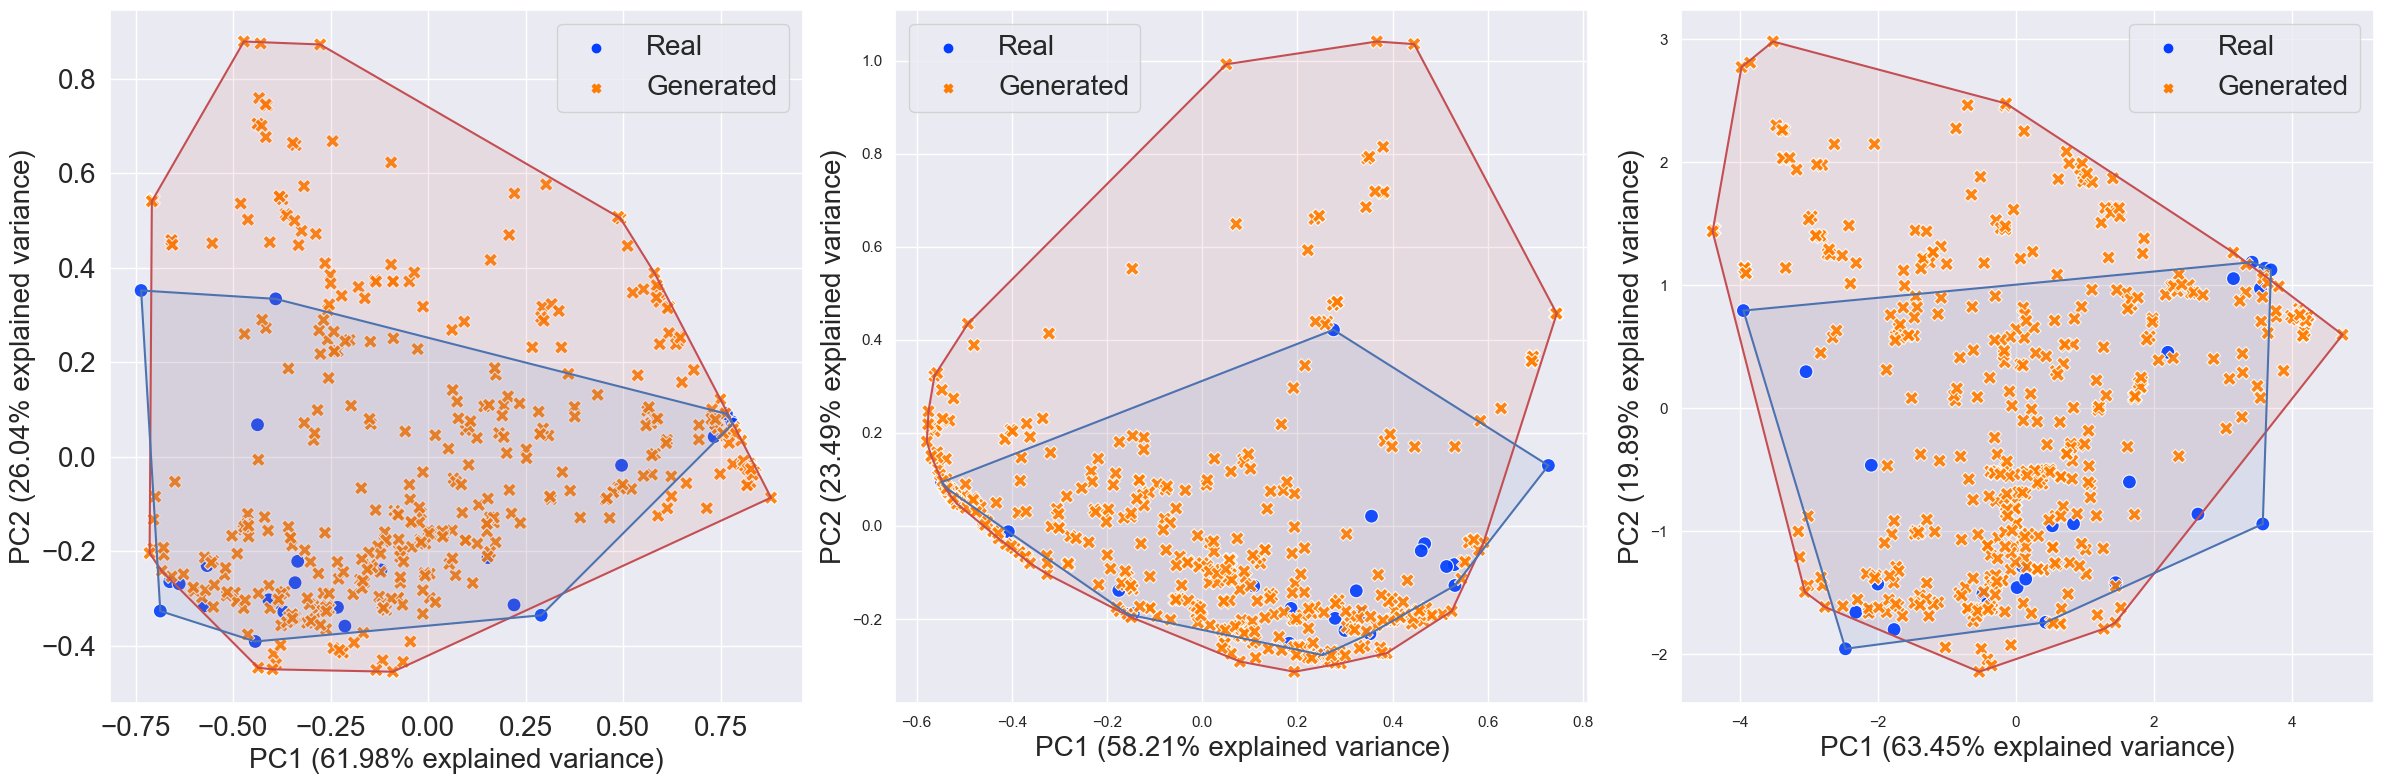

In [6]:
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

FONT_SIZE=20
def plot_convex_hull(numbers, ax, style, color):
    hull = ConvexHull(numbers)
    for simplex in hull.simplices:
        ax.plot(numbers[simplex, 0], numbers[simplex, 1], style)
    ax.fill(numbers[hull.vertices,0], numbers[hull.vertices,1], color, alpha=0.1)

pca = PCA(n_components=2)

# Normalizer: By default, L2 normalization is applied to each observation so the that the values in a row have a unit norm. 
    # Unit norm with L2 means that if each element were squared and summed, the total would equal 1. 
    #Normalizer does transform all the features to values between -1 and 1. 
#norm_data = Normalizer(norm="l2").fit_transform(df.drop(["log"], axis=1))
norm_data = Normalizer(norm="l2").fit_transform(X)

#StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. 
    #Unit variance means dividing all the values by the standard deviation.
scaler = StandardScaler()
sca_data = scaler.fit_transform(X)
#norm_data = Normalizer(norm="l2").fit_transform(norm_data)

sns.set_theme()
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24, 8), dpi=100)
#fig, ax1 = plt.subplots(figsize=(8, 8), dpi=100)

X_new = pca.fit_transform(X)
df_pca = pd.DataFrame(X_new, columns=["PC1", "PC2"])
df_pca['source']=both_df['source'].to_numpy()
numbers_gen = df_pca[df_pca['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca[df_pca['source'] == 'Real'][['PC1', 'PC2']].to_numpy()

sns.scatterplot(ax=ax1, data=df_pca, x="PC1", y="PC2", palette="bright", hue='source',
                alpha=0.9, s=100, style="source")
plot_convex_hull(numbers_gen, ax1, 'r-', 'r')
plot_convex_hull(numbers_real, ax1, 'b-', 'b')

ax1.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax1.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax1.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
ax1.tick_params(axis='both', which='minor', labelsize=FONT_SIZE)
ax1.legend(prop={'size': FONT_SIZE})

X_new_norm = pca.fit_transform(norm_data)
df_pca_norm = pd.DataFrame(X_new_norm, columns=["PC1", "PC2"])
df_pca_norm['source']=both_df['source'].to_numpy()
numbers_gen = df_pca_norm[df_pca_norm['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca_norm[df_pca_norm['source'] == 'Real'][['PC1', 'PC2']].to_numpy()
plot_convex_hull(numbers_gen, ax2, 'r-', 'r')
plot_convex_hull(numbers_real, ax2, 'b-', 'b')

sns.scatterplot(ax=ax2, data=df_pca_norm, x="PC1", y="PC2", palette="bright", hue='source', alpha=0.9, s=100, style="source")
ax2.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax2.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax2.legend(prop={'size': FONT_SIZE})

X_new_sca = pca.fit_transform(sca_data)
df_pca_sca = pd.DataFrame(X_new_sca, columns=["PC1", "PC2"])
df_pca_sca['source']=both_df['source'].to_numpy()
numbers_gen = df_pca_sca[df_pca_sca['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca_sca[df_pca_sca['source'] == 'Real'][['PC1', 'PC2']].to_numpy()
plot_convex_hull(numbers_gen, ax3, 'r-', 'r')
plot_convex_hull(numbers_real, ax3, 'b-', 'b')
sns.scatterplot(ax=ax3, data=df_pca_sca, x="PC1", y="PC2", palette="bright", hue='source', alpha=0.9, s=100, style="source")
ax3.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax3.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax3.legend(prop={'size': FONT_SIZE})

plt.tight_layout()
#plt.savefig("../output/plots/pca_GenED_baselineED.png", transparent=True)
# plt.show()
# plt.close()

In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from gedi.plotter import FeaturesPlotter

SUCCESS: Saved , plot_type='boxplot' plot in ../output/boxplots_GenED_feat_7fts_467gEL_of467.jpg


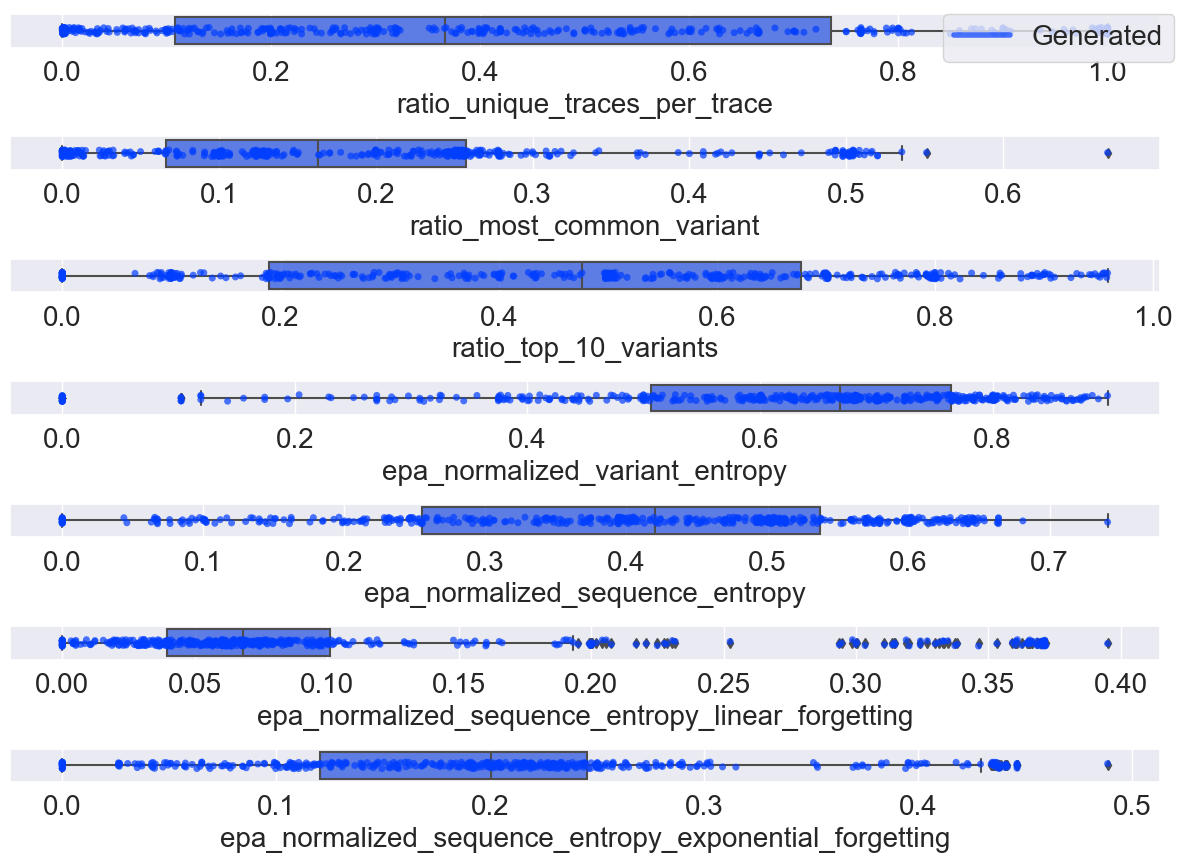

In [8]:
model_params = {"output_path":"../output", "input_path":"../data/GenED_feat.csv", "real_eventlog_path": "../data/baseline_ED_feat.csv","plot_type":"boxplot"}
FeaturesPlotter(both_df[both_df['source']=='Generated'], model_params)